In [1]:
# setup
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import (
    ColumnDataSource, Range1d, DataRange1d, DatetimeAxis,
    TickFormatter, DatetimeTickFormatter, FuncTickFormatter,
    Grid, Legend, Plot, BoxAnnotation, Span, CustomJS, Rect, Circle, Line,
    HoverTool, BoxZoomTool, PanTool, WheelZoomTool,
    WMTSTileSource, LabelSet
    )
from bokeh.models.widgets import DataTable, DateFormatter, TableColumn, Div

import numpy as np
import sys
import os

sys.path.append(os.path.join(os.getcwd(), 'plot_app'))
from pyulog import *
from pyulog.px4 import *
from plotting import *
from config import *
from notebook_helper import *

output_notebook()

Loading BokehJS ...

In [2]:
file_name = '../analyse_logs/logs/downloaded_sample/b3b5c29a-92f3-46ea-87a3-4080640187dc.ulg' # TODO: fill in file name
ulog = ULog(file_name)
data = ulog.data_list
px4_ulog = PX4ULog(ulog)
px4_ulog.add_roll_pitch_yaw()
use_downsample = False

print("message names: {:}".format(sorted([d.name for d in data])))
print_ulog_info(ulog)

message names: ['actuator_controls_0', 'actuator_outputs', 'battery_status', 'commander_state', 'control_state', 'cpuload', 'ekf2_innovations', 'ekf2_timestamps', 'estimator_status', 'input_rc', 'position_setpoint_triplet', 'rc_channels', 'sensor_combined', 'sensor_preflight', 'system_power', 'task_stack_info', 'vehicle_attitude', 'vehicle_attitude_setpoint', 'vehicle_command', 'vehicle_global_position', 'vehicle_gps_position', 'vehicle_land_detected', 'vehicle_local_position', 'vehicle_local_position_setpoint', 'vehicle_rates_setpoint', 'vehicle_status', 'wind_estimate']
System: PX4
Hardware: PX4FMU_V4
Software Version: 63306ada92d792807610dd966a7f7308ba1a70f4
Dropouts: 13 (3.71 s)
Logging duration: 0:09:47


In [3]:
use_downsample = True # you may want to activate this for large logs (But you will not see all samples when zooming in)

In [4]:
# load a dataset to inspect the field names and types
sensor_data = [ elem for elem in data if elem.name == 'vehicle_local_position' and elem.multi_id == 0][0]
types_list = [(f.type_str, f.field_name) for f in sensor_data.field_data]
for ftype, fname in types_list: print("{:10s} {:}".format(ftype, fname))

uint64_t   timestamp
uint64_t   ref_timestamp
double     ref_lat
double     ref_lon
uint64_t   surface_bottom_timestamp
float      x
float      y
float      z
float      delta_xy[0]
float      delta_xy[1]
float      delta_z
float      vx
float      vy
float      vz
float      z_deriv
float      delta_vxy[0]
float      delta_vxy[1]
float      delta_vz
float      ax
float      ay
float      az
float      yaw
float      ref_alt
float      dist_bottom
float      dist_bottom_rate
float      eph
float      epv
float      evh
float      evv
uint8_t    estimator_type
bool       xy_valid
bool       z_valid
bool       v_xy_valid
bool       v_z_valid
uint8_t    xy_reset_counter
uint8_t    z_reset_counter
uint8_t    vxy_reset_counter
uint8_t    vz_reset_counter
bool       xy_global
bool       z_global
bool       dist_bottom_valid


In [5]:
plot = plot_map(ulog, plot_config) # gps map
if plot != None: show(plot)

In [6]:
# plot raw acceleration sensor data
data_plot = DataPlot(data, plot_config, 'sensor_combined',
        y_axis_label = '[m/s^2]', title = 'Raw Acceleration', plot_height = 'normal')
data_plot.add_graph(['accelerometer_m_s2[0]', 'accelerometer_m_s2[1]', 'accelerometer_m_s2[2]'],
                    colors3, ['x', 'y', 'z'], use_downsample=use_downsample)
show(data_plot.finalize())

In [7]:
# a more complex plot with multiple datasets
data_plot = DataPlot(data, plot_config, 'sensor_combined', y_start=0, title = 'Thrust and Magnetic Field',
                     plot_height='normal')
data_plot.add_graph([lambda data: ('len_mag', 
    np.sqrt(data['magnetometer_ga[0]']**2 + data['magnetometer_ga[1]']**2 + data['magnetometer_ga[2]']**2))],
    colors2[0:1], ['Norm of Magnetic Field'], use_downsample=use_downsample)

data_plot.change_dataset('actuator_controls_0')
data_plot.add_graph([lambda data: ('thrust', data['control[3]'])], colors2[1:2], ['Thrust'],
                    use_downsample=use_downsample)

show(data_plot.finalize())

In [8]:
# plot low-pass filtered raw acceleration sensor data
from scipy.signal import butter, lfilter
cur_data = ulog.get_dataset('sensor_combined').data
t = cur_data['timestamp']

fs = len(t) / ((t[-1]-t[0])/1e6) # sample rate [Hz]
cutoff = 10 # cutoff freq [Hz]
order = 5
B, A = butter(order, cutoff / (fs / 2), btype='low') # Butterworth low-pass
filtered_signal = lfilter(B, A, cur_data['accelerometer_m_s2[0]'])

p = figure(plot_width = 800, active_scroll='wheel_zoom')
p.line(t, cur_data['accelerometer_m_s2[0]'], color='red', alpha = 0.5)
p.line(t, filtered_signal, color='blue', alpha = 0.8)
show(p)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [5]:
# get the raw acceleration
sensor_combined = ulog.get_dataset('sensor_combined').data
ax = sensor_combined['accelerometer_m_s2[0]']
ay = sensor_combined['accelerometer_m_s2[1]']
az = sensor_combined['accelerometer_m_s2[2]']
t = sensor_combined['timestamp']

In [10]:
# and plot it
p = figure(plot_width = 800, active_scroll='wheel_zoom')
p.line(t, ax, color='red', alpha = 0.8, legend="accel x")
p.line(t, ay, color='green', alpha = 0.8, legend="accel y")
p.line(t, az, color='blue', alpha = 0.8, legend="accel z")
show(p)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [11]:
# select a window
dt = (t[-1]-t[0]) / len(t) / 1e6 # delta t in seconds
start_index = int(20 / dt) # select start of window (seconds): make sure the vehicle is hovering at that point
window_len_s = 3 # window length in seconds
tw=t[start_index:int(start_index+window_len_s/dt)]
axw=ax[start_index:int(start_index+window_len_s/dt)]
ayw=ay[start_index:int(start_index+window_len_s/dt)]
azw=az[start_index:int(start_index+window_len_s/dt)]

In [12]:
# and plot it
p = figure(plot_width = 800, active_scroll='wheel_zoom')
p.line(tw, axw, color='red', alpha = 0.8, legend="accel x")
p.line(tw, ayw, color='green', alpha = 0.8, legend="accel y")
p.line(tw, azw, color='blue', alpha = 0.8, legend="accel z")
show(p)

In [13]:
# FFT frequency plot
import scipy
import scipy.fftpack
from scipy import pi

FFT_x = abs(scipy.fft(axw))
FFT_y = abs(scipy.fft(ayw))
FFT_z = abs(scipy.fft(azw))

freqs = scipy.fftpack.fftfreq(len(axw), dt)

p = figure(plot_width = 800, active_scroll='wheel_zoom')
p.line(freqs,20*scipy.log10(FFT_x), color='red', alpha = 0.8, legend="x")
p.line(freqs,20*scipy.log10(FFT_y), color='green', alpha = 0.8, legend="y")
p.line(freqs,20*scipy.log10(FFT_z), color='blue', alpha = 0.8, legend="z")
p.legend.click_policy="hide"
show(p)

In [14]:
axw.shape

(705,)

### spectogram
#### plot with matplotlib

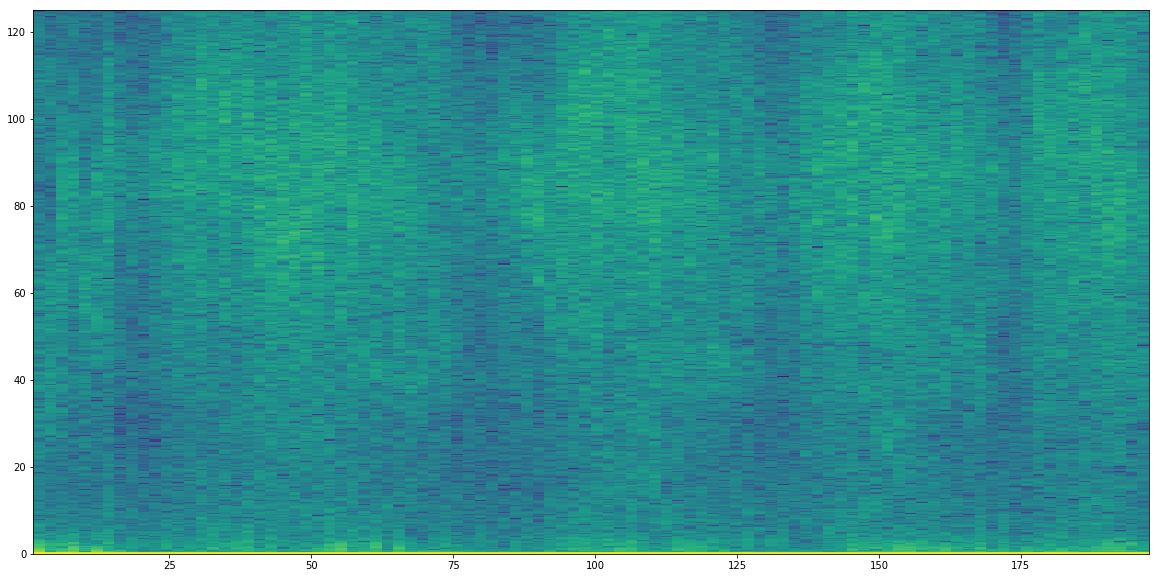

In [15]:
# plot with matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
#fs = int(1.0e6/(t[1]-t[0]))
fs = 250
plt.figure(figsize=(20,10))
spec, freq, bins, im = plt.specgram(az[:50000],Fs=fs, NFFT=1024, noverlap=512, scale='dB')

#### plot with bokeh

In [7]:
from scipy import signal
from bokeh.models import LinearColorMapper 
from bokeh.models.widgets import Select, Panel, Tabs
from bokeh.layouts import widgetbox, row, layout
from bokeh.palettes import viridis

fs = 250
Sxx = dict()
f, t, Sxx['psd_x'] = signal.spectrogram(ax,fs=fs, window='hann',nperseg=1024, noverlap=512, scaling='density')
_, _, Sxx['psd_y'] = signal.spectrogram(ay,fs=fs, window='hann',nperseg=1024, noverlap=512, scaling='density')
_, _, Sxx['psd_z'] = signal.spectrogram(az,fs=fs, window='hann',nperseg=1024, noverlap=512, scaling='density')

def plot_spec(psd):
    im = [10 * np.log10(Sxx[psd])]
    p = figure(title="Acceleration spectrogram", plot_width=900, plot_height=400,x_range=(t[0],t[-1]),y_range=(f[0],f[-1]))
    p.image(image=im, x=t[0], y=f[0], dw=t[-1], dh=f[-1],palette=viridis(256))
    p.xaxis.axis_label = "Time (s)"
    return p

tabs

In [8]:
#f, t, Sxx = signal.spectrogram(az,fs=fs, window='hann',nperseg=1024, noverlap=512, scaling='density')
#plt.figure(figsize=(20,10))
#plt.pcolormesh(t, f, 10 * np.log10(Sxx))
p_x = plot_spec('psd_x')
tab_x = Panel(child=p_x, title="psd_x")

p_y = plot_spec('psd_y')
tab_y = Panel(child=p_y, title="psd_y")

p_z = plot_spec('psd_z')
tab_z = Panel(child=p_z, title="psd_z")

tabs = Tabs(tabs=[tab_x,tab_y,tab_z])
    

#select.on_change("value",plot_spec('psd_y'))
#show(widgetbox(select))
show(tabs)

In [35]:
select = Select(title="Data:", value="psd_x", options=["psd_x", "psd_y", "psd_z"])
def update_data(attrname, old, new):
    psd = select.value
    p = plot_spec(psd)
    
p = plot_spec('psd_x')
select.on_change('value',update_data)

show(layout([select,p_x]))

#### alternatively using rect

In [ ]:
df = pd.DataFrame(pd.DataFrame(10 * np.log10(Sxx)).stack(),columns=['psd'])
df.index.names = ['Frequency','Time']
df.index.set_levels([f,t],inplace=True)
df = df.reset_index()
source = ColumnDataSource(df)
mapper = LinearColorMapper(palette=viridis(256), low=df.psd.min(), high=df.psd.max())
p = figure(plot_width=900, plot_height=400,x_range=(t[0],t[-1]),y_range=(f[0],f[-1]))
p.rect(x="Time", y="Frequency", width=(t[1]-t[0]), height=(f[1]-f[0]),
       source=source,
       fill_color={'field': 'psd', 'transform': mapper},
       line_color=None,
      dilate=True)
show(p)

#### using holoviews


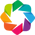

:DynamicMap   [Data]

In [41]:
import holoviews as hv
hv.extension('bokeh')
from bokeh.models import Select, Button
from bokeh.layouts import layout, column
from bokeh.io import curdoc
renderer = hv.renderer('bokeh')
#%%opts[Image[width=800,height=400]] # [cmap=viridis(256)]]
#%output info=True
f, t, Sxx_x = signal.spectrogram(ax,fs=fs, window='hann',nperseg=1024, noverlap=512, scaling='density')
_, _, Sxx_y = signal.spectrogram(ay,fs=fs, window='hann',nperseg=1024, noverlap=512, scaling='density')
_, _, Sxx_z = signal.spectrogram(az,fs=fs, window='hann',nperseg=1024, noverlap=512, scaling='density')

#%opts Image [cmap=viridis(256)]

bounds=(t[0],f[0],f[-1],t[-1])
psd_x = 10 * np.log10(Sxx_x)
psd_y = 10 * np.log10(Sxx_y)
psd_z = 10 * np.log10(Sxx_z)
ds = hv.Dataset((t,f,psd_x,psd_y,psd_z),kdims=['t','f'],vdims=['psd_x','psd_y','psd_z'])

def get_spec(data, **kwargs):
    return ds.to(hv.Image,['t','f'],vdims=[data])

plot_dict = dict(width=700,height=400)
style_dict = dict(cmap=viridis(256))

dmap = hv.DynamicMap(get_spec, kdims=['Data']).redim.values(Data=['psd_x','psd_y','psd_z']).opts(
    plot=plot_dict,style=style_dict)

#plot = renderer.get_plot(dmap)

#img = hv.Image(ds,bounds=bounds)
#dmap
#dlayout.opts(dict_spec)

button = Button(label='► Play', width=60)

#layout = column(plot,button)

'''
layout = layout([
    [plot.state],
    [button],
], sizing_mode='fixed')
'''

#curdoc().add_root(layout)
#show(plot)
#dmap
dmap